In [1]:
# Load data collection libraries
import requests
import time
import pandas as pd

# Load text processing libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
%matplotlib inline

In [2]:
# Define URL and username
url_nba= "https://www.reddit.com/r/nba.json" # This is the subreddit link for NBA
url_nfl= "https://www.reddit.com/r/nfl.json"
headers = {"User-agent": 'Masiur-Abik'}      # header to prevent 429 error

In [3]:
# Function to pull subreddit posts
def get_subreddit(url, n_pulls):    

    # Create empty templates
    posts = []
    after = None

    # Create a loop that does max 25 requests per pull
    for pull_num in range(n_pulls):
        print("Pulling data attempted", pull_num+1,"time(s)")

        if after == None:
            new_url = url                 # base case
        else:
            new_url = url+"?after="+after # subsequent iterations

        res = requests.get(new_url, headers=headers)

        if res.status_code == 200:
            subreddit_json = res.json()                      # Pull JSON
            posts.extend(subreddit_json['data']['children']) # Get subreddit posts
            after = subreddit_json['data']['after']          # 'after' = ID of the last post in this iteration
        else:
            print("We've run into an error. The status code is:", res.status_code)
            break

        time.sleep(1)
        
    return(posts)

In [4]:
nba = get_subreddit(url_nba, n_pulls = 40)


Pulling data attempted 1 time(s)
Pulling data attempted 2 time(s)
Pulling data attempted 3 time(s)
Pulling data attempted 4 time(s)
Pulling data attempted 5 time(s)
Pulling data attempted 6 time(s)
Pulling data attempted 7 time(s)
Pulling data attempted 8 time(s)
Pulling data attempted 9 time(s)
Pulling data attempted 10 time(s)
Pulling data attempted 11 time(s)
Pulling data attempted 12 time(s)
Pulling data attempted 13 time(s)
Pulling data attempted 14 time(s)
Pulling data attempted 15 time(s)
Pulling data attempted 16 time(s)
Pulling data attempted 17 time(s)
Pulling data attempted 18 time(s)
Pulling data attempted 19 time(s)
Pulling data attempted 20 time(s)
Pulling data attempted 21 time(s)
Pulling data attempted 22 time(s)
Pulling data attempted 23 time(s)
Pulling data attempted 24 time(s)
Pulling data attempted 25 time(s)
Pulling data attempted 26 time(s)
Pulling data attempted 27 time(s)
Pulling data attempted 28 time(s)
Pulling data attempted 29 time(s)
Pulling data attempted 

In [5]:
nfl = get_subreddit(url_nfl, n_pulls = 40)



Pulling data attempted 1 time(s)
Pulling data attempted 2 time(s)
Pulling data attempted 3 time(s)
Pulling data attempted 4 time(s)
Pulling data attempted 5 time(s)
Pulling data attempted 6 time(s)
Pulling data attempted 7 time(s)
Pulling data attempted 8 time(s)
Pulling data attempted 9 time(s)
Pulling data attempted 10 time(s)
Pulling data attempted 11 time(s)
Pulling data attempted 12 time(s)
Pulling data attempted 13 time(s)
Pulling data attempted 14 time(s)
Pulling data attempted 15 time(s)
Pulling data attempted 16 time(s)
Pulling data attempted 17 time(s)
Pulling data attempted 18 time(s)
Pulling data attempted 19 time(s)
Pulling data attempted 20 time(s)
Pulling data attempted 21 time(s)
Pulling data attempted 22 time(s)
Pulling data attempted 23 time(s)
Pulling data attempted 24 time(s)
Pulling data attempted 25 time(s)
Pulling data attempted 26 time(s)
Pulling data attempted 27 time(s)
Pulling data attempted 28 time(s)
Pulling data attempted 29 time(s)
Pulling data attempted 

Now that we've extracted our data, lets take a look at what our data looks like!

In [6]:
nba[0]

{'kind': 't3',
 'data': {'approved_at_utc': None,
  'subreddit': 'nba',
  'selftext': "# Today's Games:\n\n|Tip-off|Away||Home||GDT|PGT|\n|:--|:--|:-:|:--|--:|:-:|:-:|\n|8:00 PM ET|[Indiana Pacers](/r/pacers)|&gt;!135!&lt; at &gt;!134!&lt;|[Atlanta Hawks](/r/atlantahawks)|FINAL|||\n|8:00 PM ET|[Miami Heat](/r/heat)|&gt;!94!&lt; at &gt;!113!&lt;|[Brooklyn Nets](/r/gonets)|FINAL||[(Link)](https://reddit.com/r/nba/comments/bbulae)|\n|8:00 PM ET|[Orlando Magic](/r/orlandomagic)|&gt;!122!&lt; at &gt;!114!&lt;|[Charlotte Hornets](/r/charlottehornets)|FINAL||[(Link)](https://reddit.com/r/nba/comments/bburm0)|\n|8:00 PM ET|[Detroit Pistons](/r/detroitpistons)|&gt;!115!&lt; at &gt;!89!&lt;|[New York Knicks](/r/nyknicks)|FINAL||[(Link)](https://reddit.com/r/nba/comments/bbuovm)|\n|8:00 PM ET|[Chicago Bulls](/r/chicagobulls)|&gt;!109!&lt; at &gt;!125!&lt;|[Philadelphia 76ers](/r/sixers)|FINAL||[(Link)](https://reddit.com/r/nba/comments/bbun65)|\n|8:00 PM ET|[Golden State Warriors](/r/warriors)|&g

In [7]:
print('The datatype of our data is a:', type(nba[0]))


The datatype of our data is a: <class 'dict'>


In [8]:
print('Number of dictionaries:', len(nba[0]))

Number of dictionaries: 2


In [9]:
print('The two keys in our dictionary are:', nba[0].keys())

The two keys in our dictionary are: dict_keys(['kind', 'data'])


In [10]:
print(nba[0]['kind'])

# The "kind" dictionary really doesn't have any information. 
# Instead, data is a dictionary inside of the "kind" dictionary, which is the data we are interested in.

t3


In [42]:
def df_posts(post_list):
    post_titles = []
    dupes = []

    for i in range(len(post_list)):
        if post_list[i]['data']['name'] in dupes:
            pass
        else:
            title_dict = {}
            if type(post_list[i]['data']['selftext']) == str:
                title_dict['title']= post_list[i]['data']['title'] + '\n' + post_list[i]['data']['selftext']

            else:
                title_dict['title'] = post_list[i]['data']['title']
            title_dict['subreddit'] = post_list[i]['data']['subreddit']
            title_dict['Length of Title'] = len(post_list[i]['data']['title'])
            title_dict['ID'] = post_list[i]['data']['name']
            post_titles.append(title_dict)
            dupes.append(post_list[i]['data']['name'])
    return pd.DataFrame(post_titles)

In [43]:
nba_df= df_posts(nba)
nfl_df= df_posts(nfl)

In [44]:
nba_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 4 columns):
ID                 834 non-null object
Length of Title    834 non-null int64
subreddit          834 non-null object
title              834 non-null object
dtypes: int64(1), object(3)
memory usage: 26.1+ KB


In [45]:
nfl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888 entries, 0 to 887
Data columns (total 4 columns):
ID                 888 non-null object
Length of Title    888 non-null int64
subreddit          888 non-null object
title              888 non-null object
dtypes: int64(1), object(3)
memory usage: 27.8+ KB


In [46]:
nba_df['ID'].fillna('NaN', inplace=True)
nfl_df['ID'].fillna('NaN', inplace=True)


#Imputing 0's for missing values.

In [47]:
nba_df.head()

,ID,Length of Title,subreddit,title
0,t3_bbn2vb,54,nba,Game Threads Index + Daily Discussion (April 1...
1,t3_bbp5v6,60,nba,"I’m Chris Haynes, senior NBA insider for Yahoo..."
2,t3_bbujpa,69,nba,Melo ends up with the loose ball and acts like...
3,t3_bbup6y,18,nba,Dirk's last basket\n
4,t3_bbuco3,102,nba,"With Wade's assist to Haslem, he records a tri..."


In [48]:
nfl_df.head()

,ID,Length of Title,subreddit,title
0,t3_bbnpth,22,nfl,Water Cooler Wednesday\nWelcome to today's ope...
1,t3_bbteni,135,nfl,"AMA announcement: Andrae Perry, Data Analyst f..."
2,t3_bbvlo8,150,nfl,[Todd Gurley II] Man it’s so Dope how the NBA ...
3,t3_bbpdkt,117,nfl,"Jack Del Rio on AB: ""I love the talent, but An..."
4,t3_bbr8s1,263,nfl,[Garafolo] Source: The #Giants are finalizing ...


In [49]:
nba_df.shape

(834, 4)

In [50]:
nfl_df.shape

(888, 4)

In [51]:
nba_df.describe()

,Length of Title
count,834.000000
mean,88.565947
std,54.791659
min,8.000000
25%,51.000000
50%,75.000000
75%,106.000000
max,300.000000


In [52]:
nfl_df.describe()

,Length of Title
count,888.000000
mean,103.110360
std,68.417951
min,4.000000
25%,55.000000
50%,79.000000
75%,138.000000
max,294.000000


In [53]:
merged_df = pd.concat([nba_df[['title','subreddit']], nfl_df[['title', 'subreddit']]], axis = 0)

In [54]:
merged_df.tail()

,title,subreddit
883,"[Ruiter] ""I'm excited and I think it's going t...",nfl
884,[NFL Officiating] “Referee John Parry has anno...,nfl
885,[Stroud] Bucs DT Gerald McCoy did not attend t...,nfl
886,"[Schefter] With RB Duke Johnson, a no-show whe...",nfl
887,"/r/NFL Top 100 List\nHey everyone, Welcome to ...",nfl


In [55]:
merged_df.head()

,title,subreddit
0,Game Threads Index + Daily Discussion (April 1...,nba
1,"I’m Chris Haynes, senior NBA insider for Yahoo...",nba
2,Melo ends up with the loose ball and acts like...,nba
3,Dirk's last basket\n,nba
4,"With Wade's assist to Haslem, he records a tri...",nba


In [56]:
merged_df.to_csv("./merged_df.csv")

# Natural Language Processing (NLP)

In [57]:
# Load preprocessing/modeling/evaluation libraries
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeCV, LassoCV
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import  RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [58]:
merged_df['subreddit'] = merged_df['subreddit'].map({'nfl': 0, 'nba': 1})

In [59]:
X = merged_df['title']
y = merged_df['subreddit']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [61]:
merged_df['subreddit'].value_counts(normalize=True)

#Baseline value!

0    0.515679
1    0.484321
Name: subreddit, dtype: float64

In [62]:
additional_english_stop = ['www', 'things', 'does', 'x200b', 'amp',
                          'just', 'like', 'https', 'com',
                          'says', 'say', 'like', 'did', 'this', '00','10', '11', '12','13', '14', '15',
                           '16', '17', '18', '19','20',
                           'games','season', 'time', 'player', 'gt', 'reddit', 'players', 'team']

In [63]:
new_stop_list = stop_words.ENGLISH_STOP_WORDS.union(additional_english_stop)

In [64]:
# Function to count words
def word_counter(df):
    
    # Count Vectorize
    cvec = CountVectorizer(stop_words = new_stop_list)
    cvec_1 = cvec.fit_transform(df['title'])
    cvec_1 = pd.DataFrame(cvec_1.toarray(), columns= cvec.get_feature_names())
    word_count = cvec_1.sum().sort_values(ascending=False)
    
    return word_count

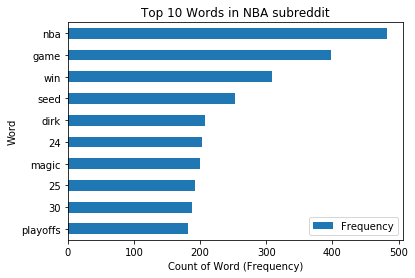

In [65]:
# Digging to find the top ten words in the NBA subreddit
nba_count = pd.DataFrame(word_counter(nba_df), columns=["Frequency"])

# Set up a horizontal bar chart to show the 10 most frequent words
nba10 = nba_count.head(10)
nba10.sort_values('Frequency').plot(kind = "barh")
plt.title("Top 10 Words in NBA subreddit")
plt.xlabel("Count of Word (Frequency)")
plt.ylabel("Word")
plt.show();

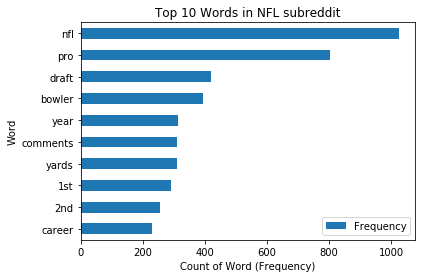

In [66]:
# Digging to find the top ten words in the NBA subreddit
nfl_count = pd.DataFrame(word_counter(nfl_df), columns=["Frequency"])

# Visualize
nfl_10 = nfl_count.head(10)
nfl_10.sort_values('Frequency').plot(kind = "barh")
plt.title("Top 10 Words in NFL subreddit")
plt.xlabel("Count of Word (Frequency)")
plt.ylabel("Word")
plt.show();

## Logistic Regression Model (Count Vectorizer)

In [67]:
log_pipe = Pipeline([
('cvec', CountVectorizer()),
('lr', LogisticRegression())
])


log_pipe_params = {
'cvec__max_features': [2500, 3000, 3500],
'cvec__ngram_range':  [(1,1), (1,2), (2,2)],
'lr__penalty':        ['l1','l2'],
"lr__random_state":   [42, 30]
}


gs_log = GridSearchCV(log_pipe, param_grid=log_pipe_params, cv=3)
gs_log.fit(X_train, y_train)
print('Best score of our model with gridsearched parameters:',gs_log.best_score_)
print('Ideal parameters:',gs_log.best_params_)
print('Score of our train model:', gs_log.score(X_train, y_train))
print('Score of our test model:', gs_log.score(X_test, y_test))

/Users/masiurabik/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best score of our model with gridsearched parameters: 0.9078233927188226
Ideal parameters: {'cvec__max_features': 3500, 'cvec__ngram_range': (1, 2), 'lr__penalty': 'l2', 'lr__random_state': 42}
Score of our train model: 0.9969016266460109
Score of our test model: 0.9373549883990719


## Multinomial Naive Bayes (Count Vectorizer)

In [68]:
nb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])


nb_pipe_params = {
'cvec__max_features': [2500, 3000, 3500],
'cvec__ngram_range':  [(1,1), (1,2), (2,2)],
'nb__alpha':          [0.1,0.5,1]
}


gs_nb = GridSearchCV(nb_pipe, param_grid=nb_pipe_params, cv=3)
gs_nb.fit(X_train, y_train)
print('Best score of our model with gridsearched parameters:',gs_nb.best_score_)
print('Ideal parameters:',gs_nb.best_params_)
print('Score of our train model:', gs_nb.score(X_train, y_train))
print('Score of our test model:', gs_nb.score(X_test, y_test))

Best score of our model with gridsearched parameters: 0.9465530596436871
Ideal parameters: {'cvec__max_features': 3000, 'cvec__ngram_range': (1, 1), 'nb__alpha': 0.1}
Score of our train model: 0.9736638264910922
Score of our test model: 0.9605568445475638


## Random Forest Model (Tfi-df Vectorizer)

In [38]:
rc_pipe = Pipeline(steps=[('tfidf', TfidfVectorizer()),
                       ('rc', RandomForestClassifier())
])


rc_pipe_params = {
"tfidf__max_features":[None],
"tfidf__ngram_range": [(1,1), (1,2)],
"tfidf__norm":        ['l1', 'l2'],
"rc__n_estimators":   [10, 20, 20],
"rc__max_depth":      [10, 20, 30],
}


gs_rc = GridSearchCV(rc_pipe, param_grid=rc_pipe_params, cv=3)
gs_rc.fit(X_train, y_train)
print('Best score of our model with gridsearched parameters:',gs_nb.best_score_)
print('Ideal parameters:',gs_rc.best_params_)
print('Score of our train model:', gs_rc.score(X_train, y_train))
print('Score of our test model:', gs_rc.score(X_test, y_test))

Best score of our model with gridsearched parameters: 0.9465530596436871
Ideal parameters: {'rc__max_depth': 30, 'rc__n_estimators': 20, 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 1), 'tfidf__norm': 'l2'}
Score of our train model: 0.9519752130131681
Score of our test model: 0.8932714617169374


## TFI-DF Support Vector Model

In [ ]:
vec_pipe = Pipeline(steps=[('tfidf', TfidfVectorizer()),
                          ('svc', svm.SVC())
                         ])

vec_pipe_params = {
"tfidf__max_features": [2000, 3000, 4000],
"tfidf__ngram_range":  [(1,1),(1,2), (2,2)],
"svc__C":              [1.0, 5.0, 15.0, 50.0],
"svc__kernel":         ['rbf', 'linear', 'sigmoid'],
"svc__gamma":          ['auto', 1.0, 5.0, 15.0] 
}



gs_vec = GridSearchCV(vec_pipe, param_grid=vec_pipe_params, cv=3)
gs_vec.fit(X_train, y_train)
print('Best score of our model with gridsearched parameters:',gs_vec.best_score_)
print('Ideal parameters:',gs_vec.best_params_)
print('Score of our train model:', gs_vec.score(X_train, y_train))
print('Score of our test model:', gs_vec.score(X_test, y_test))

>From all of the classification models, our Logistic model and Naive Bayes produced the most robust scores. Between the two models however, the Logistic model peformed better because although it had a lower train score (96%), it had a smaller difference between its train and test data (93%). This difference is indicative of how overfit the model is. Lets go on to making predictions with this model!

In [ ]:
def score_print(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Misclassification:' , 1 - accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    specificity = tn / (tn + fp)
    print('Specificity:', specificity)    

score_print(y_test, y_pred_nb)

In [ ]:
y_pred_nb= gs_nb.predict(X_test)
score_print(y_test, y_pred_nb)

- A misclassification score of 6.7% indicates the score for misclassifying the predictions into their correct classes. This is concluded to be a very low misclassification, indicative of a successful model.
- Our recall score of 91% indicates that our model was able to predict 91% of the true positives correct.
- Our specificity score of 95% indicates that our model was able to predict 95% of the true negatives correct. 
- A precision score of 94% indicates how well our model was able to predict the positives accurately.


## Conclusion

> After cleaning the data by adding common words (eg: season, games) to our stop words set from scikit learn, we incorporated this set of stop words into our count vectorizer. We then went forward with binarizing our target variables. This led to the final part of exploratory data analysis, which was to establish a baseline model. It was clearly evident from the baseline score (53%) that the baseline model would not predict the source of words accurately. All of our classification models produced better scores than our baseline model by a huge increment, concluding that all of our models are better than our baseline model. From all of the classification models, the naive bayes model using countvectorizer produced the most robust metrics and therefore, we will use this model to generate which website a given word came from. Although the model is slightly overfit, it is much more mitigated compared to the other models. The model can now identify which subreddit a given word derived from!